In [ ]:
# load dataset
import os
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import xgboost as xgb
from scipy.stats import randint as sp_randint, uniform as sp_uniform


candidates = [
    "/content/train.csv",
    "/content/data/train.csv",
    "/mnt/data/train.csv",
    "./train.csv"
]

train_path = None
for p in candidates:
    if os.path.exists(p):
        train_path = p
        break

if train_path is None:
    raise FileNotFoundError(f"Couldn't find train.csv in expected locations: {candidates}. Upload or modify the path.")

train = pd.read_csv(train_path)
test=pd.read_csv("test.csv")
print("Loaded train from:", train_path)
print("Shape:", train.shape)
display(train.head())


Loaded train from: ./train.csv
Shape: (1913, 14)


,participant_id,age_group,identity_code,cultural_background,upbringing_influence,focus_intensity,consistency_score,external_guidance_usage,support_environment_score,hobby_engagement_level,physical_activity_index,creative_expression_index,altruism_score,personality_cluster
0,643,18,1,0,4,18.118879,24,1,0,1,1,0,0,Cluster_E
1,1753,16,1,3,2,2.469271,19,0,1,0,0,0,1,Cluster_E
2,1402,17,0,2,3,3.456401,25,0,0,0,0,0,0,Cluster_E
3,2033,17,1,0,1,15.838131,25,1,2,0,0,0,0,Cluster_E
4,991,16,0,0,0,1.045373,19,1,2,0,0,1,0,Cluster_E


In [ ]:
# Prepare features, target, preprocessor 
exclude = ['participant_id', 'record_code', 'personality_cluster']
features = [c for c in train.columns if c not in exclude]
X = train[features].copy()
y = train['personality_cluster'].copy() 
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=['object','category']).columns.tolist()
print("Numeric cols:", numeric_cols)
print("Categorical cols:", categorical_cols)
num_pipeline = Pipeline([ ('imputer', SimpleImputer(strategy='median')), ('scaler', RobustScaler()) ])

preprocessor = ColumnTransformer(transformers=[ ('num', num_pipeline, numeric_cols) ], remainder='drop', sparse_threshold=0)

X_proc = pd.DataFrame(preprocessor.fit_transform(X), columns=numeric_cols, index=X.index)
print("Processed training shape:", X_proc.shape)
display(X_proc.head())

Numeric cols: ['age_group', 'identity_code', 'cultural_background', 'upbringing_influence', 'focus_intensity', 'consistency_score', 'external_guidance_usage', 'support_environment_score', 'hobby_engagement_level', 'physical_activity_index', 'creative_expression_index', 'altruism_score']
Categorical cols: []
Processed training shape: (1913, 12)


,age_group,identity_code,cultural_background,upbringing_influence,focus_intensity,consistency_score,external_guidance_usage,support_environment_score,hobby_engagement_level,physical_activity_index,creative_expression_index,altruism_score
0,1.0,0.0,0.0,2.0,0.910171,0.600000,1.0,-1.0,1.0,1.0,0.0,0.0
1,0.0,0.0,1.5,0.0,-0.746080,0.266667,0.0,-0.5,0.0,0.0,0.0,1.0
2,0.5,-1.0,1.0,1.0,-0.641609,0.666667,0.0,-1.0,0.0,0.0,0.0,0.0
3,0.5,0.0,0.0,-1.0,0.668791,0.666667,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,-1.0,0.0,-2.0,-0.896776,0.266667,1.0,0.0,0.0,0.0,1.0,0.0


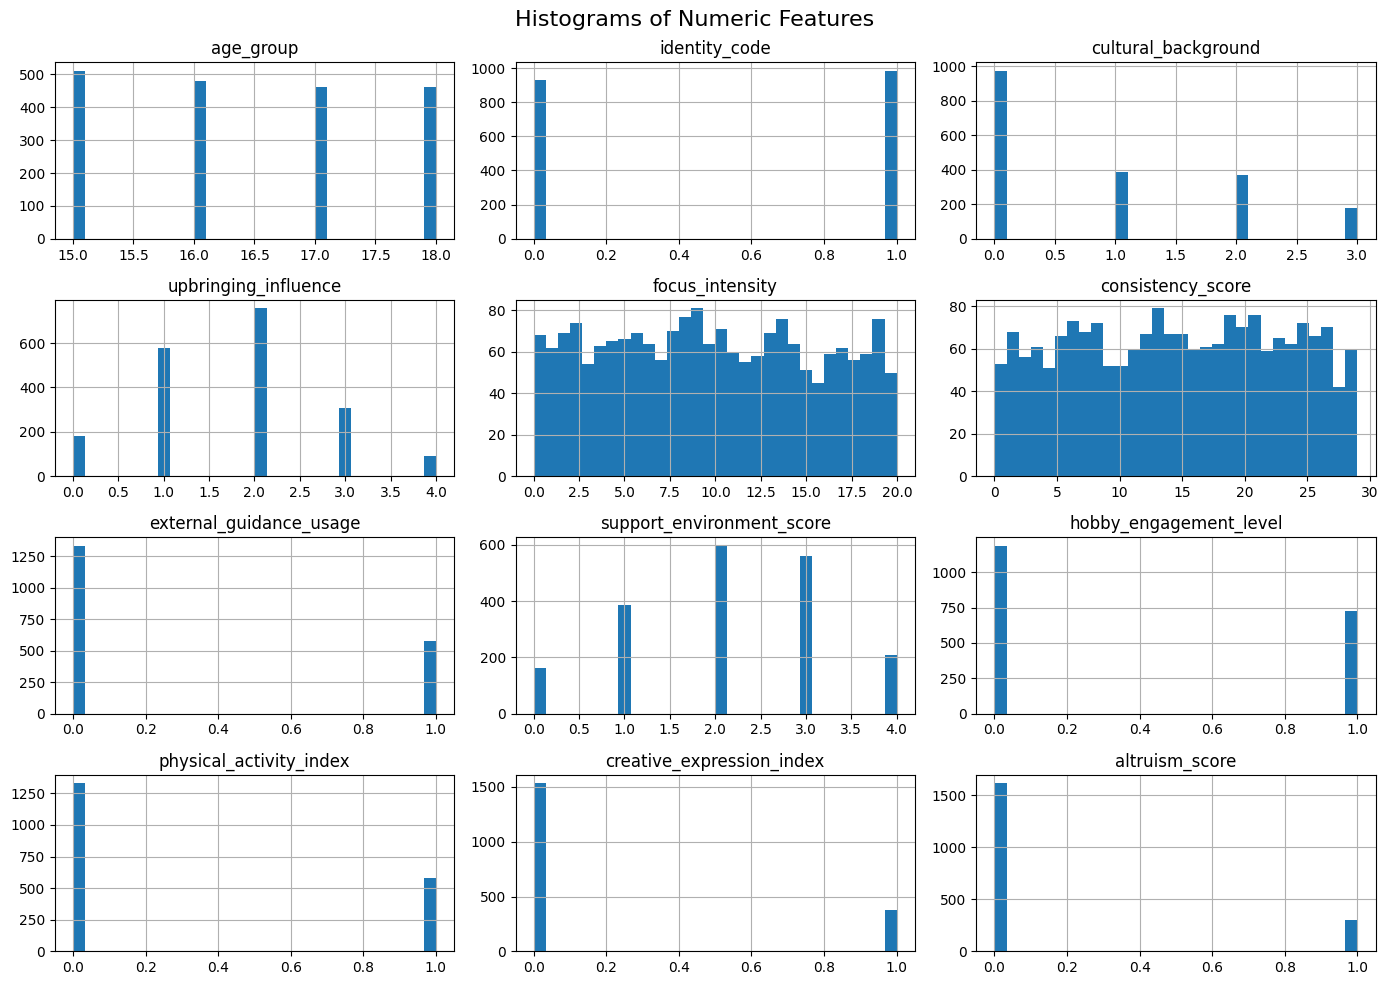

In [ ]:
X[numeric_cols].hist(figsize=(14, 10), bins=30)
plt.suptitle("Histograms of Numeric Features", fontsize=16)
plt.tight_layout()
plt.show()

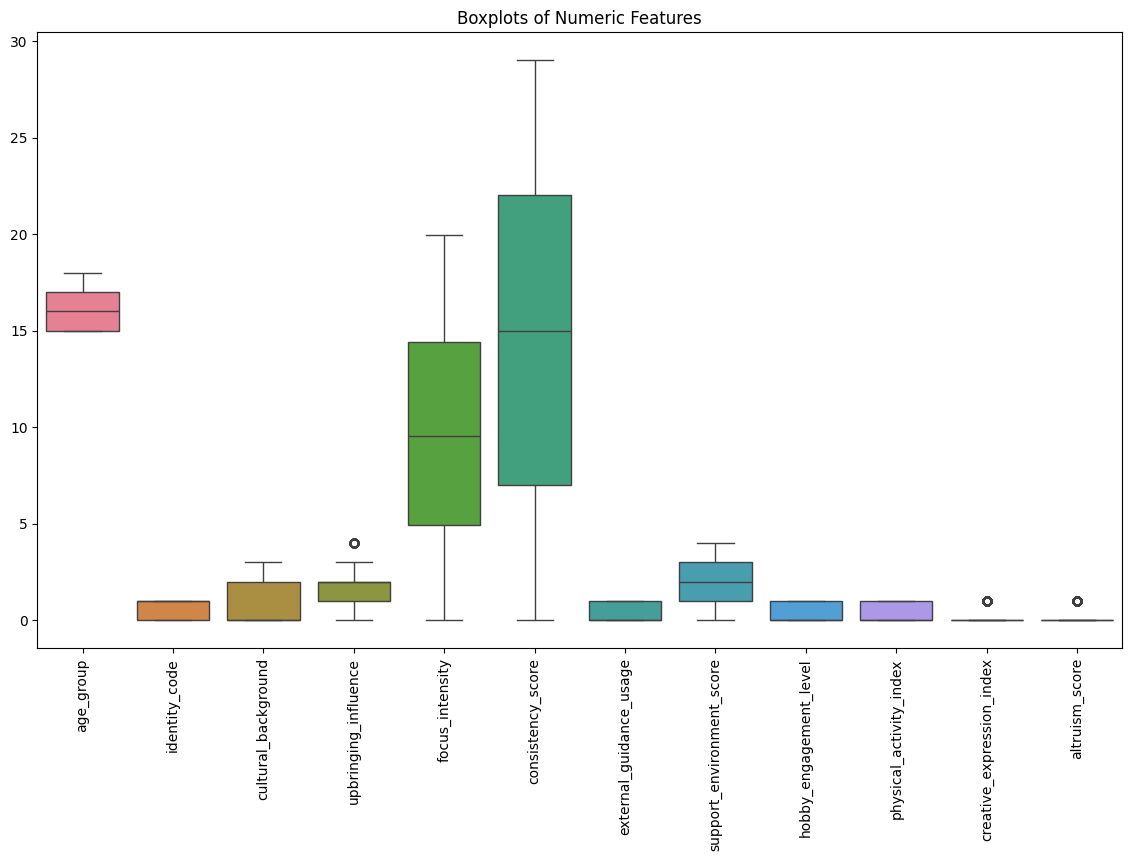

In [ ]:
plt.figure(figsize=(14, 8))
sns.boxplot(data=X[numeric_cols])
plt.xticks(rotation=90)
plt.title("Boxplots of Numeric Features")
plt.show()

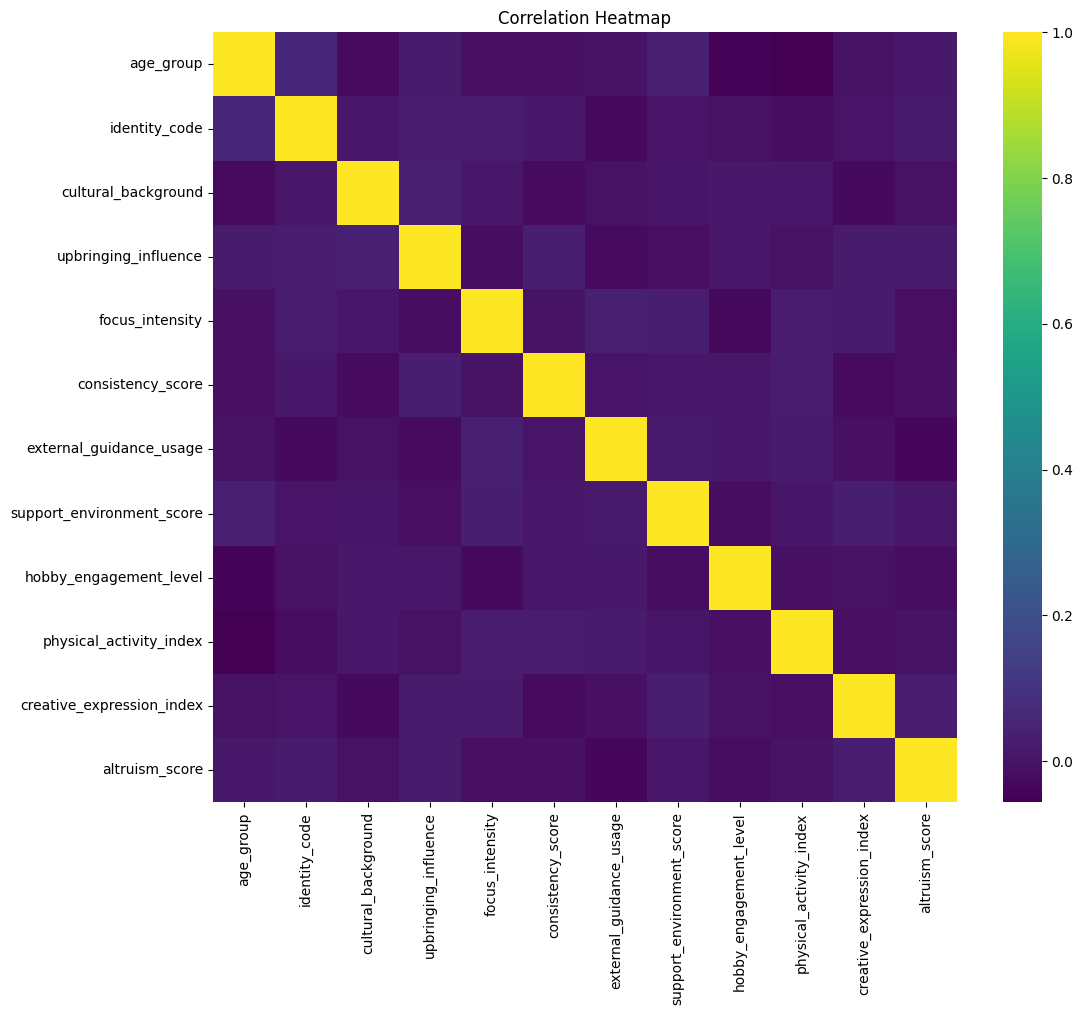

In [ ]:
plt.figure(figsize=(12, 10))
corr = X[numeric_cols].corr()
sns.heatmap(corr, annot=False, cmap="viridis")
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
# Encode target into numeric labels

from sklearn.preprocessing import LabelEncoder

TARGET_COL = "personality_cluster"
IDCOL = "participant_id"  \
\
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y)

print("Encoded classes:", le_target.classes_)
print("y_encoded shape:", y_encoded.shape)
print("X shape:", X.shape)


Encoded classes: ['Cluster_A' 'Cluster_B' 'Cluster_C' 'Cluster_D' 'Cluster_E']
y_encoded shape: (1913,)
X shape: (1913, 12)


In [ ]:
# SVM + preprocessing + submission

import numpy as np, pandas as pd, joblib
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

print("Using numeric preprocessor with columns:", preprocessor.transformers_)

# SVM model
svm_clf = LinearSVC(
    C=1.0,
    class_weight='balanced', 
    max_iter=5000,
    random_state=42
)

pipe_svm = Pipeline([
    ('pre', preprocessor),
    ('clf', svm_clf)
])




Using numeric preprocessor with columns: [('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler())]), ['age_group', 'identity_code', 'cultural_background', 'upbringing_influence', 'focus_intensity', 'consistency_score', 'external_guidance_usage', 'support_environment_score', 'hobby_engagement_level', 'physical_activity_index', 'creative_expression_index', 'altruism_score'])]



 Splitting again for training stats...
 Training SVM for model stats...

====  MODEL PERFORMANCE ====
 Train accuracy: 0.6497
 Validation accuracy: 0.6214

 Classification Report:

              precision    recall  f1-score   support

   Cluster_A       0.10      0.18      0.13        17
   Cluster_B       0.36      0.57      0.44        44
   Cluster_C       0.38      0.34      0.36        61
   Cluster_D       0.44      0.06      0.11        66
   Cluster_E       0.84      0.95      0.89       195

    accuracy                           0.62       383
   macro avg       0.43      0.42      0.39       383
weighted avg       0.61      0.62      0.59       383



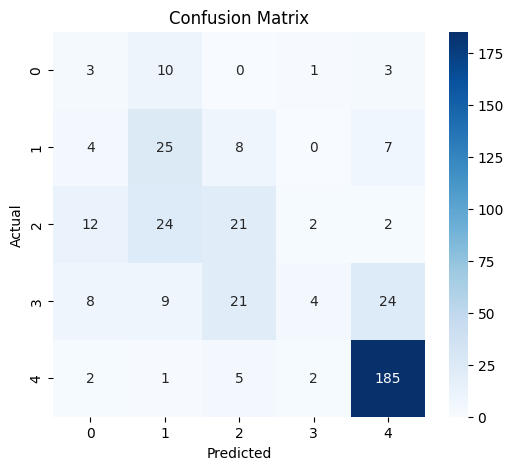


 5-Fold CV Accuracy: 0.6367 (std: 0.0123 )

 Training final SVM model on FULL data...
 SVM FULL training done.


In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

print("\n Splitting again for training stats...")
X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(" Training SVM for model stats...")
pipe_svm.fit(X_train_s, y_train_s)

print("\n====  MODEL PERFORMANCE ====")


train_acc = pipe_svm.score(X_train_s, y_train_s)
print(" Train accuracy:", round(train_acc, 4))


val_acc = pipe_svm.score(X_val_s, y_val_s)
print(" Validation accuracy:", round(val_acc, 4))


y_val_pred = pipe_svm.predict(X_val_s)
print("\n Classification Report:\n")
print(classification_report(y_val_s, y_val_pred, target_names=list(le_target.classes_)))


cm = confusion_matrix(y_val_s, y_val_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


cv_scores = cross_val_score(pipe_svm, X, y_encoded, cv=5)
print("\n 5-Fold CV Accuracy:", cv_scores.mean().round(4), "(std:", cv_scores.std().round(4), ")")


print("\n Training final SVM model on FULL data...")
pipe_svm.fit(X, y_encoded)
print(" SVM FULL training done.")


In [ ]:
# Feature engineering + preprocessing for MLP

import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

# 1) Basic setup
IDCOL = "participant_id"
TARGET_COL = "personality_cluster"
exclude = [IDCOL, 'record_code', TARGET_COL]

features = [c for c in train.columns if c not in exclude]

X_raw = train[features].copy()
y_raw = train[TARGET_COL].copy()
X_test_raw = test[features].copy()

print("Initial feature count:", X_raw.shape[1])

numeric_cols = X_raw.select_dtypes(include=[np.number]).columns.tolist()
X_num = X_raw[numeric_cols].copy()
X_test_num = X_test_raw[numeric_cols].copy()

print("Numeric columns used:", len(numeric_cols))

var = X_num.var()
keep_var_cols = var[var > 1e-6].index.tolist()
X_num = X_num[keep_var_cols]
X_test_num = X_test_num[keep_var_cols]
print("After variance filter:", len(keep_var_cols), "features")

corr = X_num.corr().abs()
upper = np.triu(np.ones(corr.shape), k=1).astype(bool)
to_drop = set()

for i, col_i in enumerate(corr.columns):
    for j, col_j in enumerate(corr.columns):
        if upper[i, j] and corr.iloc[i, j] > 0.97:
            to_drop.add(col_j)

if to_drop:
    print("Dropping highly correlated:", len(to_drop), "features")
    X_num = X_num.drop(columns=list(to_drop))
    X_test_num = X_test_num.drop(columns=list(to_drop))
else:
    print("No highly correlated features to drop.")

print("After correlation filter:", X_num.shape[1], "features")

top_k = min(8, X_num.shape[1])  # up to 8
var_sorted = X_num.var().sort_values(ascending=False)
poly_base_cols = var_sorted.index[:top_k].tolist()
print("Using for polynomial features:", poly_base_cols)

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_num[poly_base_cols])
X_test_poly = poly.transform(X_test_num[poly_base_cols])

poly_feature_names = poly.get_feature_names_out(poly_base_cols)

X_fe = pd.concat(
    [
        X_num.reset_index(drop=True),
        pd.DataFrame(X_poly, columns=[f"poly_{n}" for n in poly_feature_names])
    ],
    axis=1
)
X_test_fe = pd.concat(
    [
        X_test_num.reset_index(drop=True),
        pd.DataFrame(X_test_poly, columns=[f"poly_{n}" for n in poly_feature_names])
    ],
    axis=1
)

print("Final engineered feature shape (train):", X_fe.shape)
print("Final engineered feature shape (test):", X_test_fe.shape)

imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()

X_imputed = imputer.fit_transform(X_fe)
X_test_imputed = imputer.transform(X_test_fe)

X_all_fe = scaler.fit_transform(X_imputed)
X_test_all_fe = scaler.transform(X_test_imputed)

print("Scaled train shape:", X_all_fe.shape)
print("Scaled test shape:", X_test_all_fe.shape)

from sklearn.preprocessing import LabelEncoder

le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y_raw)

print("Classes:", le_target.classes_)
print("y_encoded shape:", y_encoded.shape)

from sklearn.model_selection import train_test_split

X_train_k, X_val_k, y_train_k, y_val_k = train_test_split(
    X_all_fe, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

print("Train split:", X_train_k.shape, "Val split:", X_val_k.shape)


Initial feature count: 12
Numeric columns used: 12
After variance filter: 12 features
No highly correlated features to drop.
After correlation filter: 12 features
Using for polynomial features: ['consistency_score', 'focus_intensity', 'age_group', 'support_environment_score', 'cultural_background', 'upbringing_influence', 'identity_code', 'hobby_engagement_level']
Final engineered feature shape (train): (1913, 56)
Final engineered feature shape (test): (479, 56)
Scaled train shape: (1913, 56)
Scaled test shape: (479, 56)
Classes: ['Cluster_A' 'Cluster_B' 'Cluster_C' 'Cluster_D' 'Cluster_E']
y_encoded shape: (1913,)
Train split: (1530, 56) Val split: (383, 56)


In [ ]:
# Keras MLP on engineered features + submission

%pip install tensorflow -q

import numpy as np, pandas as pd, joblib
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow:", tf.__version__)
print("GPUs:", tf.config.list_physical_devices('GPU'))

input_dim = X_train_k.shape[1]
n_classes = len(np.unique(y_encoded))
print("Input dim:", input_dim, "| n_classes:", n_classes)

classes = np.unique(y_encoded)
cw_arr = compute_class_weight("balanced", classes=classes, y=y_encoded)
class_weight = {int(c): float(w) for c, w in zip(classes, cw_arr)}
print("Class weights:", class_weight)

def build_mlp_multiclass():
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu',
             kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu',
             kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu',
             kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu',
             kernel_regularizer=keras.regularizers.l2(1e-4)),
        layers.Dropout(0.2),
        layers.Dense(n_classes, activation='softmax')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

model = build_mlp_multiclass()

callbacks = [
    keras.callbacks.EarlyStopping(
        patience=7,
        restore_best_weights=True,
        monitor='val_loss'
    ),
    keras.callbacks.ReduceLROnPlateau(
        patience=3,
        factor=0.5,
        min_lr=1e-5,
        monitor='val_loss'
    )
]

print("\n Training MLP on engineered features (train/val split)...")
history = model.fit(
    X_train_k, y_train_k,
    validation_data=(X_val_k, y_val_k),
    epochs=60,
    batch_size=256,
    class_weight=class_weight,
    callbacks=callbacks,
    verbose=2
)

val_probs = model.predict(X_val_k, verbose=0)
val_preds_num = np.argmax(val_probs, axis=1)
val_acc = accuracy_score(y_val_k, val_preds_num)
print("\n Validation accuracy (engineered MLP):", round(val_acc, 5))

print("\n Retraining best architecture on FULL data...")
model_full = build_mlp_multiclass()

es_full = keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor='loss'
)

history_full = model_full.fit(
    X_all_fe, y_encoded,
    epochs=len(history.history['loss']),
    batch_size=256,
    class_weight=class_weight,
    callbacks=[es_full],
    verbose=2
)

print("\n Predicting on test...")
test_probs = model_full.predict(X_test_all_fe, verbose=0)
test_preds_num = np.argmax(test_probs, axis=1)
test_preds_str = le_target.inverse_transform(test_preds_num)

IDCOL = "participant_id"
if IDCOL in test.columns:
    ids = test[IDCOL].values
else:
    ids = np.arange(len(test_preds_str))

submission_mlp = pd.DataFrame({
    IDCOL: ids,
    "personality_cluster": test_preds_str
})

out_path = "/content/submission_mlp_personality_fe.csv"
submission_mlp.to_csv(out_path, index=False)

joblib.dump(
    {"imputer": imputer, "scaler": scaler, "fe_cols": X_fe.columns.tolist()},
    "/content/preprocessor_mlp_personality_fe.joblib"
)
model_full.save("/content/keras_mlp_personality_fe.h5")

print("\n Submission saved:", out_path)
print(" Preprocessor saved:", "/content/preprocessor_mlp_personality_fe.joblib")
print(" Keras model saved:", "/content/keras_mlp_personality_fe.h5")
print(" Submission rows:", len(submission_mlp))


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'C:\\Users\\satma\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python313\\site-packages\\tensorflow\\include\\external\\com_github_grpc_grpc\\src\\core\\ext\\filters\\fault_injection\\fault_injection_service_config_parser.h'
HINT: This error might have occurred since this system does not have Windows Long Path support enabled. You can find information on how to enable this at https://pip.pypa.io/warnings/enable-long-paths


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\satma\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


ModuleNotFoundError: No module named 'tensorflow.python'

In [ ]:

# Build XGBClassifier
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    tree_method='hist',
    use_label_encoder=False,
    verbosity=0,
    random_state=42
)

param_dist = {
    'n_estimators': sp_randint(100, 1000),
    'max_depth': sp_randint(3, 12),
    'learning_rate': sp_uniform(0.01, 0.3), 
    'subsample': sp_uniform(0.5, 0.5),           
    'colsample_bytree': sp_uniform(0.5, 0.5),     
    'gamma': sp_uniform(0.0, 5.0),               
    'reg_alpha': sp_uniform(0.0, 1.0),
    'reg_lambda': sp_uniform(0.0, 1.0)
}

cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

rand_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_dist,
    n_iter=80,               
    scoring='f1_macro',
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=2,
    error_score=np.nan      
)

rand_search.fit(X_proc, y_enc, **{'xgb__sample_weight': sample_weights} if False else {})

print("Best params:", rand_search.best_params_)
print("Best CV macro-F1 (random search):", rand_search.best_score_)
best_xgb = rand_search.best_estimator_

Fitting 4 folds for each of 80 candidates, totalling 320 fits
Best params: {'colsample_bytree': np.float64(0.9868777594207296), 'gamma': np.float64(1.1638567021515211), 'learning_rate': np.float64(0.03718193035984624), 'max_depth': 5, 'n_estimators': 975, 'reg_alpha': np.float64(0.5142344384136116), 'reg_lambda': np.float64(0.5924145688620425), 'subsample': np.float64(0.5232252063599989)}
Best CV macro-F1 (random search): 0.5682309642503909


In [ ]:
# robust training cell 
import numpy as np
import joblib
import xgboost as xgb
from sklearn.metrics import f1_score, classification_report
from sklearn.utils.class_weight import compute_sample_weight

best_params = rand_search.best_params_.copy()

final_xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=len(le.classes_),
    tree_method='hist',
    use_label_encoder=False,
    verbosity=0,
    random_state=42,
    **best_params
)

X_tr, X_val, y_tr, y_val = train_test_split(X_proc, y_enc, test_size=0.15, stratify=y_enc, random_state=42)

sw_tr = compute_sample_weight('balanced', y_tr)

trained_with_sklearn_fit = False
try:
    final_xgb.fit(
        X_tr, y_tr,
        sample_weight=sw_tr,
        eval_set=[(X_val, y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=50,
        verbose=True
    )
    trained_with_sklearn_fit = True
    val_preds = final_xgb.predict(X_val)
    val_f1 = f1_score(y_val, val_preds, average='macro')
    print("Trained using XGBClassifier.fit(). Holdout macro-F1:", val_f1)
    print(classification_report(y_val, val_preds, target_names=le.classes_))

except TypeError as e:
    print("XGBClassifier.fit() didn't accept eval args (TypeError). Falling back to xgb.train().")
    print("TypeError message:", e)

    dtrain = xgb.DMatrix(X_tr, label=y_tr, weight=sw_tr)
    dval   = xgb.DMatrix(X_val, label=y_val)

    params = final_xgb.get_xgb_params()
    params['objective'] = 'multi:softprob'
    params['num_class'] = len(le.classes_)
    if 'learning_rate' in params and 'eta' not in params:
        params['eta'] = params.pop('learning_rate')

    num_round = int(params.pop('n_estimators', best_params.get('n_estimators', 1000)))

    evals = [(dtrain, 'train'), (dval, 'validation')]
    bst = xgb.train(
        params,
        dtrain,
        num_boost_round=num_round,
        evals=evals,
        early_stopping_rounds=50,
        verbose_eval=True
    )

    val_pred_proba = bst.predict(dval)
    val_preds = np.argmax(val_pred_proba, axis=1)
    val_f1 = f1_score(y_val, val_preds, average='macro')
    print("Trained using xgb.train(). Holdout macro-F1:", val_f1)
    print(classification_report(y_val, val_preds, target_names=le.classes_))

    final_xgb._Booster = bst

    best_it = getattr(bst, 'best_iteration', None)
    if best_it:
        final_xgb.set_params(n_estimators=int(best_it))
    trained_with_sklearn_fit = False

save_dir = "/content"
os.makedirs(save_dir, exist_ok=True)
if trained_with_sklearn_fit:
    joblib.dump(final_xgb, os.path.join(save_dir, "final_xgb_model_sklearn.joblib"))
    print("Saved sklearn-wrapped XGBClassifier to /content/final_xgb_model_sklearn.joblib")
else:
    booster = final_xgb._Booster
    booster.save_model(os.path.join(save_dir, "final_xgb_booster.json"))
    joblib.dump(final_xgb, os.path.join(save_dir, "final_xgb_wrapper.joblib"))
    print("Saved booster to /content/final_xgb_booster.json and wrapper to /content/final_xgb_wrapper.joblib")


XGBClassifier.fit() didn't accept eval args (TypeError). Falling back to xgb.train().
TypeError message: XGBClassifier.fit() got an unexpected keyword argument 'eval_metric'
[0]	train-mlogloss:1.58310	validation-mlogloss:1.57988
[1]	train-mlogloss:1.55446	validation-mlogloss:1.54842
[2]	train-mlogloss:1.52662	validation-mlogloss:1.51954
[3]	train-mlogloss:1.50235	validation-mlogloss:1.49165
[4]	train-mlogloss:1.47834	validation-mlogloss:1.46379
[5]	train-mlogloss:1.45439	validation-mlogloss:1.43641
[6]	train-mlogloss:1.43243	validation-mlogloss:1.41370
[7]	train-mlogloss:1.41014	validation-mlogloss:1.38959
[8]	train-mlogloss:1.38792	validation-mlogloss:1.36684
[9]	train-mlogloss:1.36738	validation-mlogloss:1.34577
[10]	train-mlogloss:1.34681	validation-mlogloss:1.32418
[11]	train-mlogloss:1.32957	validation-mlogloss:1.30737
[12]	train-mlogloss:1.31242	validation-mlogloss:1.28977
[13]	train-mlogloss:1.29649	validation-mlogloss:1.27391
[14]	train-mlogloss:1.28504	validation-mlogloss:1.26

In [ ]:
#Cross-validate the tuned final model using the preprocessor pipeline
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

pipeline_final = Pipeline([('preproc', preprocessor), ('xgb', final_xgb)])
cv_scores = cross_val_score(pipeline_final, X, y_enc, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='f1_macro', n_jobs=-1)
print("Final model CV macro-F1 mean:", cv_scores.mean(), "std:", cv_scores.std())


Final model CV macro-F1 mean: 0.551883739670276 std: 0.0077729771484101266


In [ ]:
# Robust prediction + submission cell (XGBoost)
import os
import numpy as np
import pandas as pd
import joblib
import xgboost as xgb

TEST_PATH = "/mnt/data/test.csv"
SAVE_DIR = "/content"
os.makedirs(SAVE_DIR, exist_ok=True)
OUT_PATH = os.path.join(SAVE_DIR, "submission_xgb_final.csv")

if 'test' not in globals():
    if os.path.exists(TEST_PATH):
        test = pd.read_csv(TEST_PATH)
        print("Loaded test from", TEST_PATH)
    else:
        raise FileNotFoundError("test dataframe not found in memory and /mnt/data/test.csv not present.")

test_X = test[features].copy()
test_proc = pd.DataFrame(preprocessor.transform(test_X), columns=numeric_cols, index=test.index)

pred_labels = None

try:
    if 'final_xgb' in globals() and hasattr(final_xgb, "predict"):
        if hasattr(final_xgb, "n_classes_") and hasattr(final_xgb, "classes_"):
            preds_enc = final_xgb.predict(test_proc)
            pred_labels = le.inverse_transform(preds_enc)
            print("Predicted using final_xgb.predict() (sklearn wrapper).")
        else:

            raise AttributeError("final_xgb wrapper missing sklearn attributes; will try booster fallback.")
except Exception as e:
    print("sklearn predict path not used:", str(e))

if pred_labels is None:
    booster = None
    if 'final_xgb' in globals() and hasattr(final_xgb, "_Booster") and final_xgb._Booster is not None:
        booster = final_xgb._Booster
        print("Found booster at final_xgb._Booster.")
    elif 'bst' in globals() and isinstance(bst, xgb.Booster):
        booster = bst
        print("Found booster in variable 'bst'.")
    elif os.path.exists("/content/final_xgb_booster.json"):
        # try load saved booster
        booster = xgb.Booster()
        booster.load_model("/content/final_xgb_booster.json")
        print("Loaded booster from /content/final_xgb_booster.json")
    else:
        booster = None

    if booster is None:
        raise RuntimeError("No usable trained model found. Ensure 'final_xgb' or booster exist in the notebook namespace or loaded from /content.")

    dtest = xgb.DMatrix(test_proc)
    proba = booster.predict(dtest)  
    if proba.ndim == 1:
        preds_enc = np.rint(proba).astype(int)
    else:
        preds_enc = np.argmax(proba, axis=1)

    if 'le' in globals():
        pred_labels = le.inverse_transform(preds_enc)
    else:
        pred_labels = preds_enc.astype(str)

    print("Predicted using xgboost.Booster.predict().")

# Build submission DataFrame
if 'participant_id' in test.columns:
    submission = pd.DataFrame({
        'participant_id': test['participant_id'],
        'personality_cluster': pred_labels
    })
else:
    submission = pd.DataFrame({'personality_cluster': pred_labels})

# Save submission
submission.to_csv(OUT_PATH, index=False)
print("s Submission written to:", OUT_PATH)


Rebuilt numeric_cols: ['age_group', 'identity_code', 'cultural_background', 'upbringing_influence', 'focus_intensity', 'consistency_score', 'external_guidance_usage', 'support_environment_score', 'hobby_engagement_level', 'physical_activity_index', 'creative_expression_index', 'altruism_score']
Classifier class: <class 'sklearn.svm._classes.SVC'> params to set: {'C': 1.0, 'kernel': 'rbf', 'probability': True}
Validation macro-F1: 0.45518534000052363
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        13
           1       0.46      0.33      0.39        33
           2       0.50      0.67      0.57        46
           3       0.50      0.41      0.45        49
           4       0.83      0.91      0.87       146

    accuracy                           0.68       287
   macro avg       0.46      0.47      0.46       287
weighted avg       0.64      0.68      0.65       287

Pipeline rebuilt and refit. Use 'best_model' for downstre

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
import numpy as np
import pandas as pd
import joblib
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, accuracy_score

if 'le_target' not in globals():
    le_target = LabelEncoder()
    y_encoded = le_target.fit_transform(y)

TARGET_COL = "personality_cluster"
IDCOL = "participant_id"

print("Using numeric preprocessor with columns:", preprocessor.transformers_)

log_reg_clf = LogisticRegression(
    solver='liblinear',
    multi_class='ovr',
    class_weight='balanced',
    max_iter=1000,
    random_state=42
)

pipe_log_reg = Pipeline([
    ('pre', preprocessor),
    ('clf', log_reg_clf)
])

X_train_s, X_val_s, y_train_s, y_val_s = train_test_split(
    X, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Fit model
print("\nTraining Logistic Regression on full data...")
pipe_log_reg.fit(X_train_s, y_train_s)
print("Logistic Regression training done.")

train_preds = pipe_log_reg.predict(X_train_s)
val_preds = pipe_log_reg.predict(X_val_s)

print("\n===== MODEL PERFORMANCE STATS =====")
print(f"Train accuracy: {accuracy_score(y_train_s, train_preds):.4f}")
print(f"Validation accuracy: {accuracy_score(y_val_s, val_preds):.4f}")

print("\nClassification Report (Validation Set):")
print(classification_report(y_val_s, val_preds, target_names=le_target.classes_))

print("\nCalculating cross-validation score for Logistic Regression...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores_log_reg = cross_val_score(pipe_log_reg, X, y_encoded,
                                    cv=cv, scoring='f1_macro', n_jobs=1)

print(f"Logistic Regression CV macro-F1 mean: {cv_scores_log_reg.mean():.5f} "
      f"std: {cv_scores_log_reg.std():.5f}")

test_features = test[features].copy()

log_reg_preds_num = pipe_log_reg.predict(test_features)
log_reg_preds_str = le_target.inverse_transform(log_reg_preds_num)

if IDCOL in test.columns:
    ids = test[IDCOL].values
else:
    ids = np.arange(len(log_reg_preds_str))

submission_log_reg = pd.DataFrame({
    IDCOL: ids,
    "personality_cluster": log_reg_preds_str
})

out_log_reg = "/content/submission_log_reg_personality.csv"
submission_log_reg.to_csv(out_log_reg, index=False)

joblib.dump(pipe_log_reg, "/content/log_reg_personality_model.joblib")

print("\nLogistic Regression submission saved:", out_log_reg)
print("Logistic Regression model saved:", "/content/log_reg_personality_model.joblib")
print("Submission rows:", len(submission_log_reg))


Using numeric preprocessor with columns: [('num', Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', RobustScaler())]), ['age_group', 'identity_code', 'cultural_background', 'upbringing_influence', 'focus_intensity', 'consistency_score', 'external_guidance_usage', 'support_environment_score', 'hobby_engagement_level', 'physical_activity_index', 'creative_expression_index', 'altruism_score'])]

Training Logistic Regression on full data...
Logistic Regression training done.

===== MODEL PERFORMANCE STATS =====
Train accuracy: 0.6739
Validation accuracy: 0.6554

Classification Report (Validation Set):
              precision    recall  f1-score   support

   Cluster_A       0.14      0.24      0.18        17
   Cluster_B       0.47      0.48      0.47        44
   Cluster_C       0.43      0.43      0.43        61
   Cluster_D       0.56      0.27      0.37        66
   Cluster_E       0.84      0.93      0.88       195

    accuracy                 

C:\Users\satma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1281: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\satma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
C:\Users\satma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages